# AirBNB Ciudad de México (Análisis)

En este notebook se practica el uso de Polars, Plotly y TensorFlow con un dataset de Airbnb en la Ciudad de México.

Importación de librerías

In [1]:
import polars as pl
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10,6)
alt.data_transformers.enable('default', max_rows=None)

print("Librerías listas.")

Librerías listas.


Carga y Limpieza de Datos

In [2]:
url = "https://data.insideairbnb.com/mexico/df/mexico-city/2025-03-19/data/listings.csv.gz"
print(f"Cargando {url}")

df = pl.read_csv(url)

df = df.with_columns(
    pl.col("price")
    .str.replace_all(r"[\$,]", "")
    .cast(pl.Float64)
    .alias("price")
).drop_nulls(subset=["price"]).filter(pl.col("price") > 0)

print("Datos cargados:", df.shape)
df.head()

Cargando https://data.insideairbnb.com/mexico/df/mexico-city/2025-03-19/data/listings.csv.gz
Datos cargados: (22068, 79)


id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,…,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
i64,str,i64,str,str,str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,str,str,str,str,str,str,f64,f64,str,str,i64,f64,str,…,i64,i64,i64,i64,i64,f64,f64,str,str,i64,i64,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,str,str,f64,f64,f64,f64,f64,f64,f64,str,str,i64,i64,i64,i64,f64
35797,"""https://www.airbnb.com/rooms/3…",20250319150644,"""2025-03-21""","""city scrape""","""Villa Dante""","""Dentro de Villa un estudio de …","""Santa Fe Shopping Mall, Interl…","""https://a0.muscache.com/pictur…",153786,"""https://www.airbnb.com/users/s…","""Dici""","""2010-06-28""","""Mexico City, Mexico""","""Master in visual arts, film ph…","""N/A""","""N/A""","""N/A""","""f""","""https://a0.muscache.com/im/pic…","""https://a0.muscache.com/im/pic…",null,1,1,"""['email', 'phone', 'work_email…","""t""","""t""","""Mexico City, D.f., Mexico""","""Cuajimalpa de Morelos""",null,19.38283,-99.27178,"""Entire villa""","""Entire home/apt""",2,1.0,"""1 bath""",…,7,1,1,7,7,1.0,7.0,null,"""t""",28,58,88,363,"""2025-03-21""",0,0,0,284,0,0,0,null,null,null,null,null,null,null,null,null,null,"""f""",1,1,0,0,null
56074,"""https://www.airbnb.com/rooms/5…",20250319150644,"""2025-03-20""","""city scrape""","""Great space in historical San …","""This great apartment is locate…","""Very traditional neighborhood …","""https://a0.muscache.com/pictur…",265650,"""https://www.airbnb.com/users/s…","""Maris""","""2010-10-19""","""Mexico City, Mexico""","""I am a University Professor no…","""within a day""","""88%""","""100%""","""f""","""https://a0.muscache.com/im/use…","""https://a0.muscache.com/im/use…","""San Rafael""",1,5,"""['email', 'phone']""","""t""","""t""","""Mexico City, DF, Mexico""","""Cuauhtémoc""",null,19.43977,-99.15605,"""Entire condo""","""Entire home/apt""",2,1.0,"""1 bath""",…,250,15,15,250,250,15.0,250.0,null,"""t""",26,56,86,361,"""2025-03-20""",84,1,1,283,0,30,17550,"""2011-04-02""","""2025-02-27""",4.87,4.95,4.88,4.98,4.94,4.76,4.79,null,"""f""",1,1,0,0,0.49
70644,"""https://www.airbnb.com/rooms/7…",20250319150644,"""2025-03-22""","""city scrape""","""Beautiful light Studio Coyoaca…","""COYOACAN designer studio quiet…","""Coyoacan is a beautiful neighb…","""https://a0.muscache.com/pictur…",212109,"""https://www.airbnb.com/users/s…","""Trisha""","""2010-08-24""","""Mexico City, Mexico""","""I am a mother, documentary fil…","""within a few hours""","""100%""","""93%""","""t""","""https://a0.muscache.com/im/use…","""https://a0.muscache.com/im/use…","""Coyoacán""",3,4,"""['email', 'phone', 'work_email…","""t""","""t""","""Mexico City, Federal District,…","""Coyoacán""",null,19.35448,-99.16217,

Análisis

In [3]:
avg_price = df.select(pl.col("price").mean()).item()
print(f"Precio promedio por noche: ${avg_price:,.2f} MXN")

room_types = df.group_by("room_type").agg(pl.len().alias("count")).sort("count", descending=True)
print("\nTipos de alojamiento más comunes:")
print(room_types)

top_neigh = df.group_by("neighbourhood_cleansed").agg(pl.len().alias("count")).sort("count", descending=True).head(5)
print("\nDelegaciones con más alojamientos:")
print(top_neigh)

Precio promedio por noche: $1,665.01 MXN

Tipos de alojamiento más comunes:
shape: (4, 2)
┌─────────────────┬───────┐
│ room_type       ┆ count │
│ ---             ┆ ---   │
│ str             ┆ u32   │
╞═════════════════╪═══════╡
│ Entire home/apt ┆ 14843 │
│ Private room    ┆ 6995  │
│ Shared room     ┆ 169   │
│ Hotel room      ┆ 61    │
└─────────────────┴───────┘

Delegaciones con más alojamientos:
shape: (5, 2)
┌────────────────────────┬───────┐
│ neighbourhood_cleansed ┆ count │
│ ---                    ┆ ---   │
│ str                    ┆ u32   │
╞════════════════════════╪═══════╡
│ Cuauhtémoc             ┆ 10434 │
│ Miguel Hidalgo         ┆ 3764  │
│ Benito Juárez          ┆ 2482  │
│ Coyoacán               ┆ 1362  │
│ Álvaro Obregón         ┆ 799   │
└────────────────────────┴───────┘


Visualizaciones

In [4]:
df_plot = df.filter(pl.col("price") < df.select(pl.col("price").quantile(0.95))).to_pandas()

fig_price = px.histogram(df_plot, x="price", nbins=40, title="Distribución de precios (95% más bajo)")
fig_price.show()

fig_room = px.bar(room_types.to_pandas(), x="room_type", y="count", title="Alojamientos por tipo")
fig_room.show()

fig_neigh = px.bar(top_neigh.to_pandas(), x="neighbourhood_cleansed", y="count", title="Top 5 delegaciones")
fig_neigh.show()

Modelo con TensorFlow

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = ["latitude","longitude","minimum_nights","number_of_reviews","availability_365"]
target = "price"

model_df = df.select(features+[target]).drop_nulls().to_pandas()
X = model_df[features]
y = model_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = keras.Sequential([
    layers.Dense(64, activation="relu", input_shape=[len(features)]),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(X_train_scaled, y_train, epochs=50, validation_split=0.2, verbose=0)

loss, mae = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"MAE en test: ${mae:,.2f} MXN")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



MAE en test: $1,151.55 MXN


Resultados

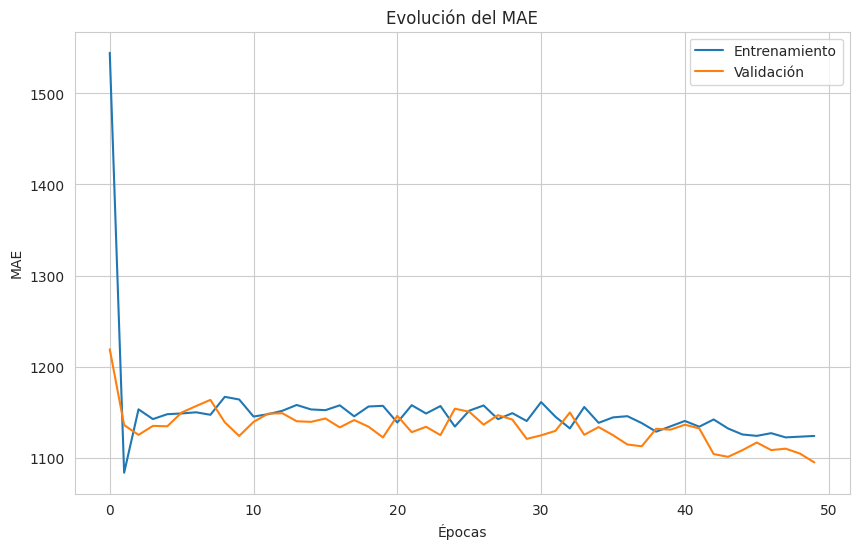

In [6]:
plt.plot(history.history["mae"], label="Entrenamiento")
plt.plot(history.history["val_mae"], label="Validación")
plt.title("Evolución del MAE")
plt.xlabel("Épocas")
plt.ylabel("MAE")
plt.legend()
plt.show()